<div style="text-align: center;">

**Data Science and Economics  
Master's Program**  

*University of Milan*  
  
Machine Learning Module Final Project  

**Student:** [*Amirali Davary*](https://github.com/amiralid)  
**Date:** *May 2025*

</div>

# Project 2: Tree Predictors for Binary Classification

This project focuses on implementing tree-based predictors from scratch to perform binary classification on the [Mushroom dataset](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset). The goal is to predict whether a mushroom is **poisonous** or **edible** based on its features.

The tree predictors are designed according to the following principles:
- **Single-feature binary tests** are applied at internal nodes, using thresholds for numerical features or membership tests for categorical features.
- A **node structure** is implemented to include attributes such as leaf status, child nodes, and a decision function.
- A **tree predictor class** is built, featuring:
  - Multiple **splitting criteria** (Gini impurity, entropy, and misclassification error).
  - **Stopping conditions** such as maximum tree depth and minimum sample splits.
  - Procedures for **training** on a given dataset and **evaluation** on unseen data.

In addition, the implementation is extended to a **Random Forest** classifier by combining multiple tree predictors, each trained on a bootstrapped sample with random feature selection at each split.

This notebook includes:
- Preprocessing of the Mushroom dataset.
- Custom implementations of decision trees and random forests.
- Training and evaluation using metrics including accuracy, precision, recall, F1-score, specificity, and AUC.
- **Hyperparameter tuning** via grid search and cross-validation to optimize tree configurations.
- Analysis and discussion of model performance, including observations on overfitting and underfitting.  

  
---

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    zero_one_loss,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
from itertools import product

import pickle
import os
from graphviz import Digraph

In [63]:
# Load Data
file_path = './secondary_data.csv'
mushroom_data = pd.read_csv(file_path, delimiter=';')
mushroom_data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [64]:
pd.DataFrame({
    'column': mushroom_data.columns,
    'null-count': mushroom_data.isna().sum().values,
    '% null-count': np.round(mushroom_data.isna().sum().values*100/len(mushroom_data),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,57892,94.797688
1,spore-print-color,54715,89.595376
2,veil-color,53656,87.861272
3,stem-root,51538,84.393064
4,stem-surface,38124,62.427746
5,gill-spacing,25063,41.040462
6,cap-surface,14120,23.121387
7,gill-attachment,9884,16.184971
8,ring-type,2471,4.046243
9,class,0,0.000000


In [65]:
# Count missing values in each column
missing_counts = mushroom_data.isnull().sum()
missing_percent = (missing_counts / len(mushroom_data)) * 100

# Drop columns with more than 50% missing values
columns_to_drop = missing_percent[missing_percent > 50].index
mushroom_data_cleaned = mushroom_data.drop(columns=columns_to_drop)

columns_dropped = list(columns_to_drop)
cleaned_shape = mushroom_data_cleaned.shape

columns_dropped, cleaned_shape


(['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color'],
 (61069, 16))

In [66]:
print('duplicates in raw data:', mushroom_data_cleaned.duplicated().sum())
mushroom_data_cleaned.drop_duplicates(inplace=True)
print('duplicates in processed data:', mushroom_data_cleaned.duplicated().sum())

duplicates in raw data: 146
duplicates in processed data: 0


In [101]:

# Separate Features and the Target class
X = mushroom_data_cleaned.drop(columns=["class"])
y = mushroom_data_cleaned["class"]

# Encode the target variable: 'p' -> 1 (poisonous), 'e' -> 0 (edible)
y_encoded = y.map({'p': 1, 'e': 0})

# Encode categorical features using Label Encoding (suitable for decision trees)
X_encoded = X.copy()
label_encoders = {}

for column in X_encoded.columns:
    if X_encoded[column].dtype == 'object':
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
        label_encoders[column] = le

### Decision Tree Dfinition

In [102]:
# Node class for the decision tree
class TreeNode:
    def __init__(self, is_leaf=False, prediction=None, feature_index=None, threshold=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = None
        self.right = None

    def decision_function(self, x):
        if self.is_leaf:
            return self.prediction
        return x[self.feature_index] <= self.threshold

# Decision Tree Classifier Definition
class DecisionTreeClassifierCustom:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini'):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion

    def _gini(self, y):
        classes = np.unique(y)
        return 1.0 - sum((np.sum(y == c) / len(y)) ** 2 for c in classes)

    def _entropy(self, y):
        from math import log2
        classes = np.unique(y)
        entropy = 0
        for c in classes:
            p = np.sum(y == c) / len(y)
            if p > 0:
                entropy -= p * log2(p)
        return entropy
    
    def _misclassification_error(self, y):
        counts = np.bincount(y)
        return 1.0 - np.max(counts) / len(y)

    def _impurity(self, y):
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        elif self.criterion == 'misclassification':
            return self._misclassification_error(y)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _best_split(self, X, y):
        best_score = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if len(y[left_mask]) < self.min_samples_split or len(y[right_mask]) < self.min_samples_split:
                    continue
                left_score = self._impurity(y[left_mask])
                right_score = self._impurity(y[right_mask])
                score = (len(y[left_mask]) * left_score + len(y[right_mask]) * right_score) / len(y)
                if score < best_score:
                    best_score, best_feature, best_threshold = score, feature_index, threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return TreeNode(is_leaf=True, prediction=np.bincount(y).argmax())
        
        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            return TreeNode(is_leaf=True, prediction=np.bincount(y).argmax())

        node = TreeNode(feature_index=feature_index, threshold=threshold)
        left_mask = X[:, feature_index] <= threshold
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        return node

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _predict_sample(self, x, node):
        while not node.is_leaf:
            if node.decision_function(x):
                node = node.left
            else:
                node = node.right
        return node.prediction

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

### Random Forest Definition

In [69]:
class RandomForestCustom:
    def __init__(self, n_estimators=50, max_depth=None, min_samples_split=2, 
                 criterion='gini', max_features='sqrt', bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features = max_features  # 'sqrt', 'log2', or int
        self.bootstrap = bootstrap
        self.trees = []
        self.features_indices = []

    def _sample_features(self, n_features):
        if self.max_features == 'sqrt':
            return np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
        elif self.max_features == 'log2':
            return np.random.choice(n_features, int(np.log2(n_features)), replace=False)
        elif isinstance(self.max_features, int):
            return np.random.choice(n_features, self.max_features, replace=False)
        else:
            return np.arange(n_features)

    def fit(self, X, y):
        self.trees = []
        self.features_indices = []

        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            if self.bootstrap:
                indices = np.random.choice(n_samples, size=n_samples, replace=True)
            else:
                indices = np.arange(n_samples)

            X_sample = X[indices]
            y_sample = y[indices]

            # Random feature selection
            feature_indices = self._sample_features(n_features)
            self.features_indices.append(feature_indices)

            # Train a tree on the selected features
            tree = DecisionTreeClassifierCustom(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion=self.criterion
            )

            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

    def _majority_vote(self, predictions):
        return Counter(predictions).most_common(1)[0][0]

    def predict(self, X):
        tree_preds = np.array([
            tree.predict(X[:, features])
            for tree, features in zip(self.trees, self.features_indices)
        ])
        # Majority vote along axis 0
        return np.apply_along_axis(self._majority_vote, axis=0, arr=tree_preds)

### K-fold Cross Validation

In [105]:
def k_fold_cross_validation_with_metrics(model_class, X, y, k=5, show_cm=False, show_roc=True, model_name="Model", verbose=True, **model_kwargs):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    if verbose:
        print(f"\nFold {fold + 1} - {model_name}")
    
    metrics_list = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'specificity': [],
        'auc': []
    }

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = model_class(**model_kwargs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Confusion matrix and scores
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        auc_score = auc(*roc_curve(y_test, y_pred)[:2])

        metrics_list['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics_list['precision'].append(precision_score(y_test, y_pred))
        metrics_list['recall'].append(recall_score(y_test, y_pred))
        metrics_list['f1'].append(f1_score(y_test, y_pred))
        metrics_list['specificity'].append(specificity)
        metrics_list['auc'].append(auc_score)

        print(f"\nFold {fold + 1} - {model_name}")
        print(f"Accuracy    : {metrics_list['accuracy'][-1]:.4f}")
        print(f"Precision   : {metrics_list['precision'][-1]:.4f}")
        print(f"Recall      : {metrics_list['recall'][-1]:.4f}")
        print(f"F1 Score    : {metrics_list['f1'][-1]:.4f}")
        print(f"Specificity : {metrics_list['specificity'][-1]:.4f}")
        print(f"AUC         : {metrics_list['auc'][-1]:.4f}")

        if show_cm:
            ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible", "Poisonous"]).plot()
            plt.title(f"{model_name} - Fold {fold+1} Confusion Matrix")
            plt.show()

        if show_roc:
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            plt.plot(fpr, tpr, label=f"Fold {fold+1} (AUC={auc_score:.2f})")

    # Summary
    print(f"\n===== {model_name} Cross-Validation Summary =====")
    for key, values in metrics_list.items():
        print(f"{key.capitalize():<12}: {np.mean(values):.4f} ± {np.std(values):.4f}")

    if show_roc:
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    return metrics_list

### hyperparameter tuning

In [ ]:
# Grid Search Function

def grid_search(model_class, param_grid, X, y, k=5, scoring='accuracy', model_name="Model"):
    best_score = -float('inf')
    best_params = None
    results = []

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    for combination in product(*values):
        params = dict(zip(keys, combination))

        print(f"Testing parameters: {params}")
        metrics = k_fold_cross_validation_with_metrics(
            model_class,
            X, y,
            k=k,
            model_name=model_name,
            show_cm=False,
            show_roc=False,
            verbose=False,
            **params
        )

        # Scoring metric
        if scoring == 'accuracy':
            score = np.mean(metrics['accuracy'])
        elif scoring == 'f1':
            score = np.mean(metrics['f1'])
        elif scoring == 'auc':
            score = np.mean(metrics['auc'])
        else:
            raise ValueError(f"Unknown scoring metric: {scoring}")

        results.append((params, score))

        if score > best_score:
            best_score = score
            best_params = params

    print(f"\nBest Parameters for {model_name}: {best_params}")
    print(f"Best {scoring}: {best_score:.4f}")
    return best_params, results


Function to evaluate models

In [72]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible (0)", "Poisonous (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

Function to plot ROC

In [ ]:
def plot_roc_curve(y_true, y_scores, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Function for feature importance

In [74]:
def compute_tree_feature_importance(tree_model, n_features):
    importances = np.zeros(n_features)

    def traverse(node):
        if node is None or node.is_leaf:
            return
        if node.feature_index is not None:
            importances[node.feature_index] += 1
        traverse(node.left)
        traverse(node.right)

    traverse(tree_model.root)
    return importances / np.sum(importances) if np.sum(importances) > 0 else importances

def compute_rf_feature_importance(rf_model, n_features):
    importances = np.zeros(n_features)

    for tree, features in zip(rf_model.trees, rf_model.features_indices):
        stack = [tree.root]
        while stack:
            node = stack.pop()
            if not node.is_leaf and node.feature_index is not None:
                real_index = features[node.feature_index]  # Map to original feature index
                importances[real_index] += 1
                stack.append(node.left)
                stack.append(node.right)

    return importances / np.sum(importances)  # Normalize

### Model Training

Split Dataset into Train and Test

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded.values, y_encoded.values,
    test_size=0.2, random_state=42
)

### Decision Tree

In [12]:
# Initialize and train initial decision tree
tree = DecisionTreeClassifierCustom(
    max_depth=10,                # or tune this
    min_samples_split=5,         # stopping criterion
    criterion='gini'             # or 'entropy'
)
tree.fit(X_train, y_train)

# Make predictions
train_preds = tree.predict(X_train)
test_preds = tree.predict(X_test)

# Evaluate using 0-1 loss
train_error = zero_one_loss(y_train, train_preds)
test_error = zero_one_loss(y_test, test_preds)

# Print results
print(f"Training Error (0-1 loss): {train_error:.4f}")
print(f"Testing Error (0-1 loss): {test_error:.4f}")

Training Error (0-1 loss): 0.0992
Testing Error (0-1 loss): 0.1078



=== Initial Decision Tree Evaluation ===
Accuracy    : 0.8922
Precision   : 0.9712
Recall      : 0.8320
F1 Score    : 0.8962
Specificity : 0.9687


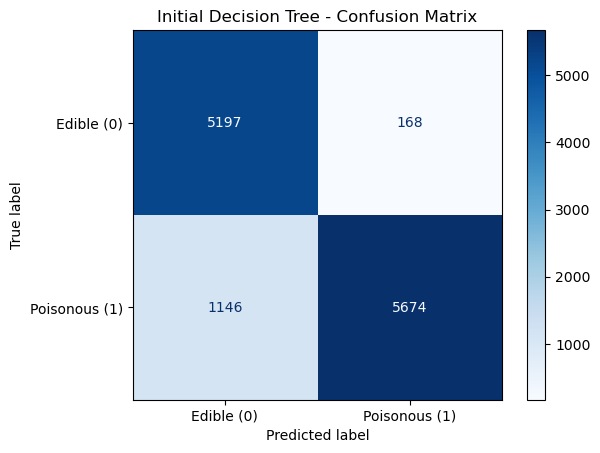

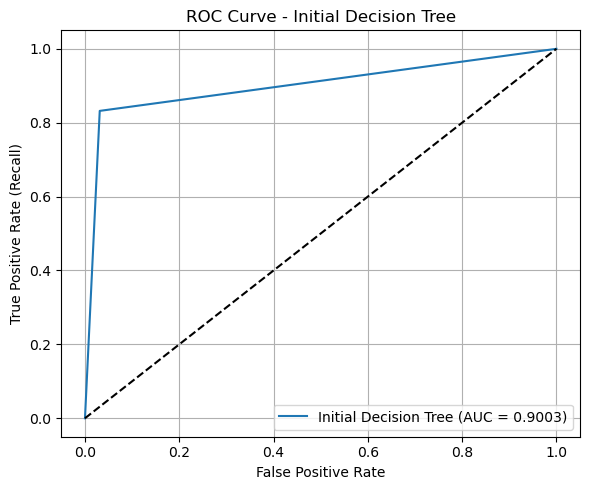

In [45]:
evaluate_model(y_test, test_preds, model_name="Initial Decision Tree")
plot_roc_curve(y_test, test_preds, model_name="Initial Decision Tree")

Feature Importance: Initial Decision Tree

stem-width: 0.1701
cap-diameter: 0.1361
cap-surface: 0.0952
stem-height: 0.0884
gill-attachment: 0.0816
cap-color: 0.0680
gill-spacing: 0.0680
stem-color: 0.0680
gill-color: 0.0544
cap-shape: 0.0476
ring-type: 0.0408
does-bruise-or-bleed: 0.0340
habitat: 0.0204
has-ring: 0.0136
season: 0.0136


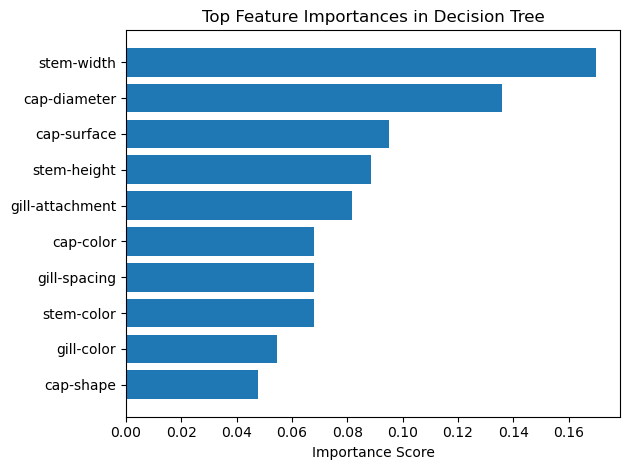

In [42]:
# Single decision tree f. importances
tree_importances = compute_tree_feature_importance(tree, X_encoded.shape[1])

# Map to feature names
tree_feature_importance_dict = dict(zip(X_encoded.columns, tree_importances))
sorted_tree_importances = dict(sorted(tree_feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Display top features
for feature, importance in sorted_tree_importances.items():
    print(f"{feature}: {importance:.4f}")

# select top features
top_n = 10
top_features = list(sorted_tree_importances.keys())[:top_n]
top_scores = list(sorted_tree_importances.values())[:top_n]

plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top Feature Importances in Decision Tree")
plt.tight_layout()
plt.show()


### Random Forest

In [13]:
# Instantiate and train random forest
rf = RandomForestCustom(n_estimators=50, max_depth=10, max_features='sqrt')
rf.fit(X_train, y_train)

# Predict and evaluate
rf_train_preds = rf.predict(X_train)
rf_test_preds = rf.predict(X_test)

rf_train_error = zero_one_loss(y_train, rf_train_preds)
rf_test_error = zero_one_loss(y_test, rf_test_preds)

print(f"Random Forest Training Error (0-1 loss): {rf_train_error:.4f}")
print(f"Random Forest Testing Error (0-1 loss): {rf_test_error:.4f}")

Random Forest Training Error (0-1 loss): 0.0739
Random Forest Testing Error (0-1 loss): 0.0810



=== Initial Random Forest Evaluation ===
Accuracy    : 0.9190
Precision   : 0.9049
Recall      : 0.9557
F1 Score    : 0.9296
Specificity : 0.8723


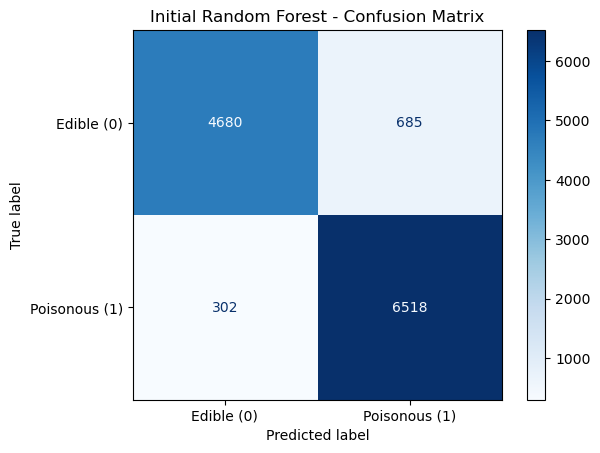

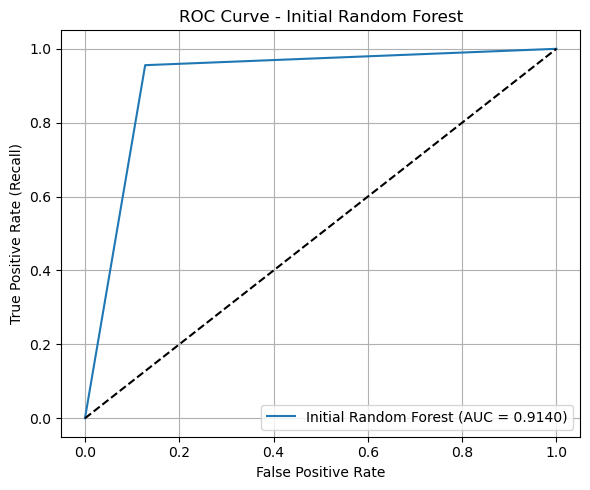

In [46]:
evaluate_model(y_test, rf_test_preds, model_name="Initial Random Forest")
plot_roc_curve(y_test, rf_test_preds, model_name="Initial Random Forest")

Feature Importance: Initial Random Forest

cap-diameter: 0.3256
stem-height: 0.2344
stem-width: 0.1434
gill-color: 0.0520
cap-surface: 0.0499
stem-color: 0.0299
gill-attachment: 0.0295
habitat: 0.0239
season: 0.0230
ring-type: 0.0216
cap-color: 0.0180
cap-shape: 0.0179
gill-spacing: 0.0168
does-bruise-or-bleed: 0.0073
has-ring: 0.0067


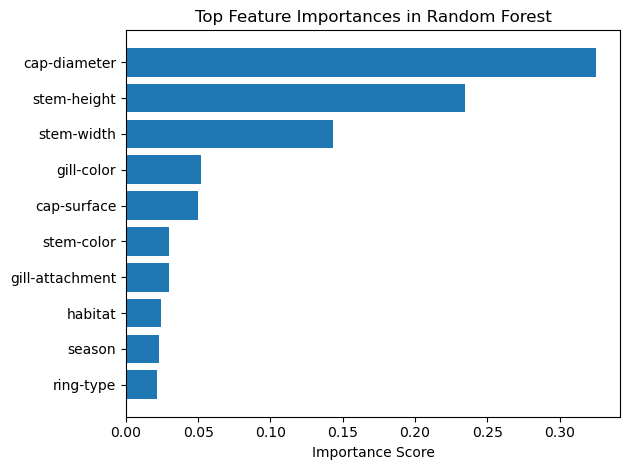

In [43]:
# random forest f. importances
rf_importances = compute_rf_feature_importance(rf, X_encoded.shape[1])

# Combine with feature names
feature_importance_dict = dict(zip(X_encoded.columns, rf_importances))
sorted_importances = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Display top features
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# select top features
top_n = 10
top_features = list(sorted_importances.keys())[:top_n]
top_scores = list(sorted_importances.values())[:top_n]

plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top Feature Importances in Random Forest")
plt.tight_layout()
plt.show()


Grid Search

In [79]:
# Decision Tree Grid
tree_param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['misclassification', 'entropy', 'gini']
}

# Run grid search for decision tree
best_tree_params, tree_results = grid_search(
    DecisionTreeClassifierCustom,
    tree_param_grid,
    X_encoded.values,
    y_encoded.values,
    k=5,
    scoring='accuracy',
    model_name="Custom Decision Tree"
)

Testing parameters: {'max_depth': 5, 'min_samples_split': 2, 'criterion': 'misclassification'}

Fold 1 - Custom Decision Tree
Accuracy    : 0.7535
Precision   : 0.7539
Recall      : 0.8309
F1 Score    : 0.7905
Specificity : 0.6552
AUC         : 0.7431

Fold 2 - Custom Decision Tree
Accuracy    : 0.7611
Precision   : 0.7518
Recall      : 0.8447
F1 Score    : 0.7956
Specificity : 0.6588
AUC         : 0.7518

Fold 3 - Custom Decision Tree
Accuracy    : 0.7622
Precision   : 0.7567
Recall      : 0.8406
F1 Score    : 0.7965
Specificity : 0.6649
AUC         : 0.7528

Fold 4 - Custom Decision Tree
Accuracy    : 0.7409
Precision   : 0.7622
Recall      : 0.7653
F1 Score    : 0.7637
Specificity : 0.7114
AUC         : 0.7383

Fold 5 - Custom Decision Tree
Accuracy    : 0.7631
Precision   : 0.7489
Recall      : 0.8664
F1 Score    : 0.8034
Specificity : 0.6325
AUC         : 0.7494

===== Custom Decision Tree Cross-Validation Summary =====
Accuracy    : 0.7562 ± 0.0084
Precision   : 0.7547 ± 0.0045
R

In [80]:
# best tree params
best_tree_params

{'max_depth': 20, 'min_samples_split': 2, 'criterion': 'gini'}

Save the grid search results as CSV

In [81]:
tree_results_df = pd.DataFrame([ {**params, 'score': score} for params, score in tree_results])
os.makedirs('./gridSearch_results', exist_ok=True)
tree_results_df.to_csv('./gridSearch_results/tree_gs_results.csv', index=False)
tree_results_df

,max_depth,min_samples_split,criterion,score
0,5,2,misclassification,0.756167
1,5,2,entropy,0.649886
2,5,2,gini,0.669911
3,5,5,misclassification,0.755921
4,5,5,entropy,0.649886
5,5,5,gini,0.669895
6,5,10,misclassification,0.755905
7,5,10,entropy,0.649903
8,5,10,gini,0.669878
9,10,2,misclassification,0.842242


In [23]:

# Random Forest Grid
rf_param_grid = {
    'n_estimators': [30, 50],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Run grid search for random forest
best_rf_params, rf_results = grid_search(
    RandomForestCustom,
    rf_param_grid,
    X_encoded.values,
    y_encoded.values,
    k=5,
    scoring='accuracy',
    model_name="Custom Random Forest"
)

Testing parameters: {'n_estimators': 30, 'max_depth': 5, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'gini'}

Fold 1 - Custom Random Forest
Accuracy    : 0.7764
Precision   : 0.7804
Recall      : 0.8358
F1 Score    : 0.8071
Specificity : 0.7010
AUC         : 0.7684

Fold 2 - Custom Random Forest
Accuracy    : 0.7492
Precision   : 0.7043
Recall      : 0.9381
F1 Score    : 0.8046
Specificity : 0.5181
AUC         : 0.7281

Fold 3 - Custom Random Forest
Accuracy    : 0.7868
Precision   : 0.7607
Recall      : 0.8971
F1 Score    : 0.8233
Specificity : 0.6500
AUC         : 0.7736

Fold 4 - Custom Random Forest
Accuracy    : 0.7655
Precision   : 0.7353
Recall      : 0.8929
F1 Score    : 0.8065
Specificity : 0.6116
AUC         : 0.7522

Fold 5 - Custom Random Forest
Accuracy    : 0.8112
Precision   : 0.7943
Recall      : 0.8935
F1 Score    : 0.8409
Specificity : 0.7072
AUC         : 0.8003

===== Custom Random Forest Cross-Validation Summary =====
Accuracy    : 0.7778 ± 0.0208


In [59]:
# best rf params
best_rf_params

{'n_estimators': 50,
 'max_depth': 10,
 'min_samples_split': 2,
 'max_features': 'log2',
 'criterion': 'gini'}

Save the grid search results as CSV

In [82]:
# Accuracy Random Forest
rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_test, rf_test_preds)

print(f"Random Forest Training Accuracy: {rf_train_accuracy:.4f}")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy:.4f}")

Random Forest Training Accuracy: 0.9261
Random Forest Testing Accuracy: 0.9190


In [56]:
rf_results_df = pd.DataFrame([ {**params, 'score': score} for params, score in rf_results])
os.makedirs('./gridSearch_results', exist_ok=True)
rf_results_df.to_csv('./gridSearch_results/rf_gs_results.csv', index=False)
rf_results_df

,n_estimators,max_depth,min_samples_split,max_features,criterion,score
0,30,5,2,sqrt,gini,0.777835
1,30,5,2,sqrt,entropy,0.768773
2,30,5,2,log2,gini,0.775586
3,30,5,2,log2,entropy,0.764998
4,30,5,5,sqrt,gini,0.766409
5,30,5,5,sqrt,entropy,0.779147
6,30,5,5,log2,gini,0.785450
7,30,5,5,log2,entropy,0.755855
8,30,10,2,sqrt,gini,0.902270
9,30,10,2,sqrt,entropy,0.900021


Train Final Tuned Models


=== Final Tuned Decision Tree Evaluation ===
Accuracy    : 0.9942
Precision   : 0.9953
Recall      : 0.9943
F1 Score    : 0.9948
Specificity : 0.9940


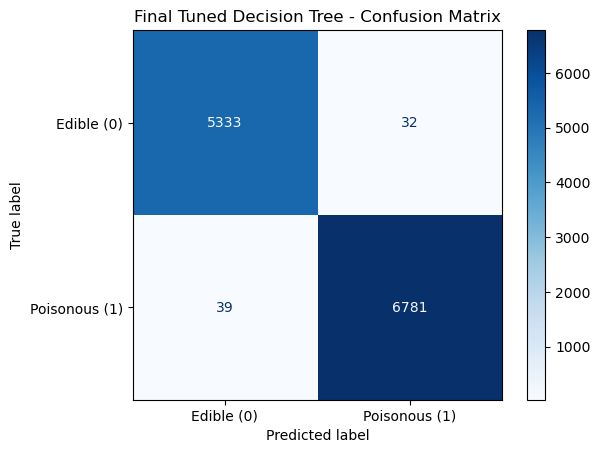

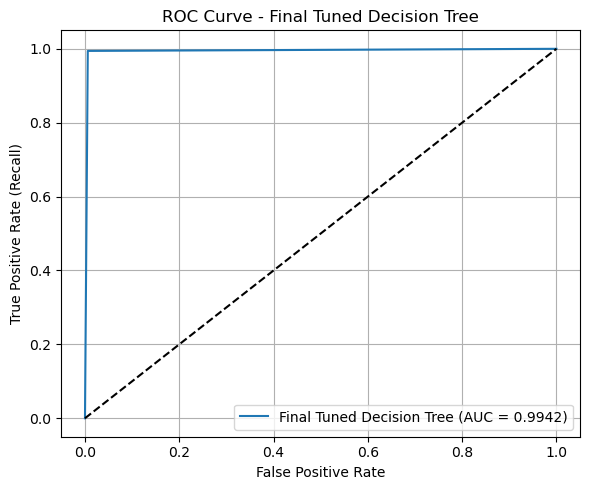

In [83]:
# Train final tree with best hyperparameters
final_tree = DecisionTreeClassifierCustom(**best_tree_params)
final_tree.fit(X_train, y_train)
final_tree_preds = final_tree.predict(X_test)

evaluate_model(y_test, final_tree_preds, model_name="Final Tuned Decision Tree")
plot_roc_curve(y_test, final_tree_preds, model_name="Final Tuned Decision Tree")

cap-diameter: 0.1654
cap-surface: 0.1163
stem-width: 0.1085
gill-attachment: 0.1008
stem-height: 0.1008
cap-color: 0.0930
gill-spacing: 0.0568
gill-color: 0.0568
cap-shape: 0.0491
stem-color: 0.0465
ring-type: 0.0362
habitat: 0.0258
does-bruise-or-bleed: 0.0233
has-ring: 0.0129
season: 0.0078


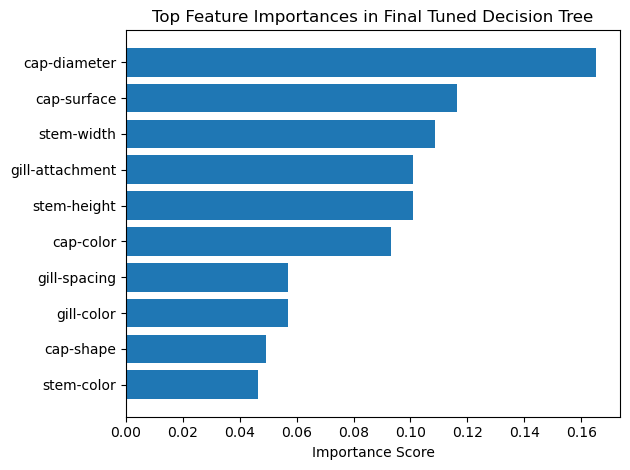

In [84]:
# Tuned decision tree feature importances
final_tree_importances = compute_tree_feature_importance(final_tree, X_encoded.shape[1])

# Map to feature names
Final_tree_feature_importance_dict = dict(zip(X_encoded.columns, final_tree_importances))
sorted_final_tree_importances = dict(sorted(Final_tree_feature_importance_dict.items(),
                                            key=lambda x: x[1], reverse=True))

# Display top features
for feature, importance in sorted_final_tree_importances.items():
    print(f"{feature}: {importance:.4f}")

# select top features
top_n = 10
top_features = list(sorted_final_tree_importances.keys())[:top_n]
top_scores = list(sorted_final_tree_importances.values())[:top_n]

plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top Feature Importances in Final Tuned Decision Tree")
plt.tight_layout()
plt.show()


=== Final Tuned Random Forest Evaluation ===
Accuracy    : 0.9226
Precision   : 0.9062
Recall      : 0.9613
F1 Score    : 0.9329
Specificity : 0.8734


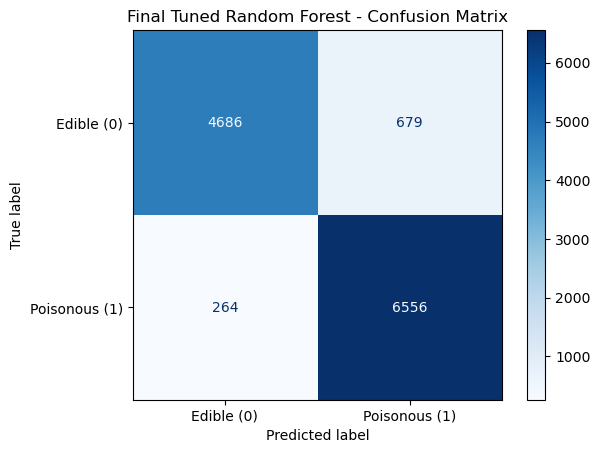

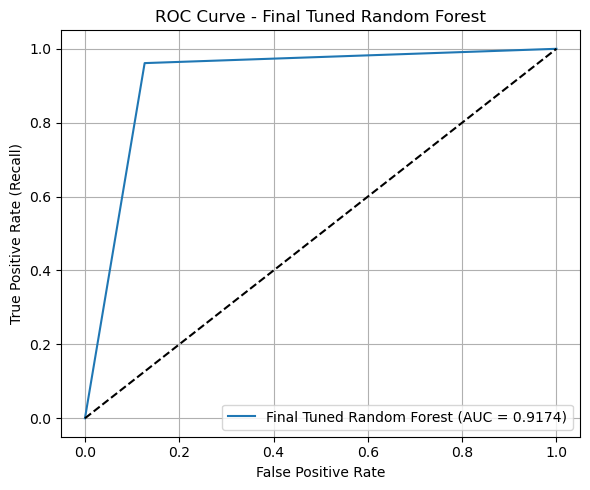

In [31]:
# Train final Random Forest with best hyperparameters
final_rf = RandomForestCustom(**best_rf_params)
final_rf.fit(X_train, y_train)
final_rf_preds = final_rf.predict(X_test)

evaluate_model(y_test, final_rf_preds, model_name="Final Tuned Random Forest")
plot_roc_curve(y_test, final_rf_preds, model_name="Final Tuned Random Forest")

stem-height: 0.2358
cap-diameter: 0.1944
stem-width: 0.1910
stem-color: 0.0462
cap-color: 0.0459
cap-shape: 0.0431
cap-surface: 0.0399
gill-attachment: 0.0362
gill-color: 0.0341
gill-spacing: 0.0306
season: 0.0258
ring-type: 0.0235
habitat: 0.0235
does-bruise-or-bleed: 0.0166
has-ring: 0.0133


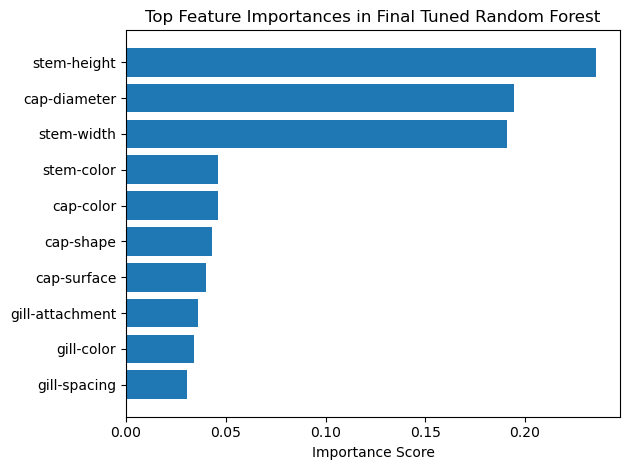

In [49]:
# random forest f. importances
final_rf_importances = compute_rf_feature_importance(final_rf, X_encoded.shape[1])

# Combine with feature names
final_rf_feature_importance_dict = dict(zip(X_encoded.columns, final_rf_importances))
final_rf_sorted_importances = dict(sorted(final_rf_feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Display top features
for feature, importance in final_rf_sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# select top features
top_n = 10
top_features = list(final_rf_sorted_importances.keys())[:top_n]
top_scores = list(final_rf_sorted_importances.values())[:top_n]

plt.barh(top_features[::-1], top_scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top Feature Importances in Final Tuned Random Forest")
plt.tight_layout()
plt.show()


### Serialize the models to be loaded in the future

In [ ]:
# Create the directory if it doesn't exist
os.makedirs('./Final_Models', exist_ok=True)

# Save tree model as .pkl file
with open('./Final_Models/final_tree.pkl', 'wb') as f:
    pickle.dump(final_tree, f)

# Save rf model as .pkl file
with open('./Final_Models/final_rf.pkl', 'wb') as f:
    pickle.dump(final_rf, f)

In [ ]:
# Load the model from the file
with open('./Final_Models/final_tree.pkl', 'rb') as f:
    loaded_tree_Model = pickle.load(f)

# Load the model from the file
with open('./Final_Models/final_rf.pkl', 'rb') as f:
    loaded_rf_Model = pickle.load(f)

In [87]:
best_rf_params

{'n_estimators': 50,
 'max_depth': 10,
 'min_samples_split': 2,
 'max_features': 'log2',
 'criterion': 'gini'}

In [88]:
best_tree_params

{'max_depth': 20, 'min_samples_split': 2, 'criterion': 'gini'}

Visualize the Decision Tree ***diagram*** with graphviz

In [99]:
def visualize_tree_with_class_colors(node, feature_names, dot=None, node_id=0):
    if dot is None:
        dot = Digraph()
    
    current_id = str(node_id)
    
    if node.is_leaf:
        # Color based on prediction class
        if node.prediction == 0:
            fillcolor = 'lightgreen'  # Edible (Class 0)
        else:
            fillcolor = 'lightcoral'  # Poisonous (Class 1)
        
        label = f"Predict: {node.prediction}"
        dot.node(current_id, label, style='filled', fillcolor=fillcolor, fontcolor='black', color='black')
    else:
        feature = feature_names[node.feature_index]
        label = f"{feature} <= {node.threshold}"
        dot.node(current_id, label, style='filled', fillcolor='lightblue', fontcolor='black', color='black')
    
    if not node.is_leaf:
        left_id = str(node_id * 2 + 1)
        right_id = str(node_id * 2 + 2)
        
        dot.edge(current_id, left_id, label="True")
        dot.edge(current_id, right_id, label="False")
        
        visualize_tree_with_class_colors(node.left, feature_names, dot, node_id * 2 + 1)
        visualize_tree_with_class_colors(node.right, feature_names, dot, node_id * 2 + 2)
    
    return dot

In [100]:
dot = visualize_tree_with_class_colors(final_tree.root, list(mushroom_data.columns))
dot.render('colored_class_tree', format='png', cleanup=False)
dot.view()

'colored_class_tree.pdf'